# Yeast CarbonSources, part 2


## Introduction

This is analysis of a public dataset (PRIDE [PXD002875](https://www.ebi.ac.uk/pride/archive/projects/PXD002875)) from Paulo, O'Connell, Gaun, and Gygi:

> Paulo, J.A., O’Connell, J.D., Gaun, A. and Gygi, S.P., 2015. Proteome-wide quantitative multiplexed profiling of protein expression: carbon-source dependency in Saccharomyces cerevisiae. Molecular biology of the cell, 26(22), pp.4063-4074.

There were 24 RAW files of yeast grown in three different carbon sources. It was a 3x3 (9-plex) TMT experiment done with the SPS MS3 (MultiNotch) method (**ref-1**).

Here are some ballpark numbers from the published paper. There were about 4700 quantifiable proteins at a low FDR. The 3 by 3 study design was tested for differential expression significance using a one-way ANOVA test with a Bonferroni multiple testing correction. 1003 proteins were found to be significant at a corrected p-value cutoff of 0.01.

---

## Contunuation of analysis from [Part 1](CarbonSources.ipynb)

In Part 1, we loaded the data from the PAW pipeline processing and checked normalizations. We looked at some global characterestics of data within biological conditions (galactose, glucose, or raffinise carbon sources) and between conditions (scatter plots, clustering, and CV distributions).

We then did some pairwise comparsions between conditions using edgeR. In each comparison, we had very large numbers of statistically significant differential expression (DE) candidates. The publication above did a one-way ANOVA test. In fact, there are many tests we could use (probably hundreds). How much do the results depend on the choice of test (and related parameters)?

## Explore one pairwise test to see how choices affect results

Pairwise comparisons are easier to interpret and visualize that multiple-conditions. We will pick the galactose versus glucose comparison for the next parts of this notebook. We have n=3 biological replicates for each condition. This means we can use traditional test options like a two-sample t-test. It has been demonstrated in many studies that the basic t-test for these low replicate numbers is not very robust. If we think about the situation, we have low replicate numbers per gene/protein, but we have a lots of genes/proteins. Can we use characteristics of more than single genes/proteins to improve the tests? Yes. The R packkage limma uses moderated test statistics to make the variance estimates more robust. EdgeR had many of the same developers and uses similar methods. There are other widely used packages that do similar things. 

### Normalizations, transformations, missing data, test variations

There are many other factors beside the statistical test that affects results. Normalizations can be pretty important and more complicated factors like batch effects add even more complications to normalization choices. With many tests that are commonly used having assumptions of normally distributed data, transformations to log scales are also common. I guess the assumption is that when in doubt assume the data is log normal. Log transformations have real problems with zero values. This leads to how to handle missing data. If you think normalizations are a complicvate topic, wait until you start researching missing data imputation.

Many statistical models have options or variations. Even a two-sample t-test has options. The more complicated testing alternatives usually have even more options. Sometimes there are recommended ways to determine what options to use, athough many of those may not work well with small replicate numbers. Is it scientifically ethical to pick the test/options that you like the results from the best? Or is that yet another definition of bias?

### Multiple testing corrections

These larger scale experiments (genomics or proteomics) also employ multiple testing corrections to adjust the statistical test p-values to try and control error rates. Given a dataset, different statistical tests will produce differnet p-values. Differnet options for a given statistical test will produce differnet p-values. Different normalization methods will affect the p-values. Data transformations may affect p-values. Now, we have several different options for multiple testing corrections. Each of the different methods will produce different final adjusted p-values.

### How to explore choices systematically

The number of combinations gets out of hand in a hurry. We could have a couple of normalization options (matched totals or matched medians), linear or log transformations, some different tests (t-test, edgeR, limma) each with a couple of options, and a couple of multiple testing corrections (Benjamini-Hochberg and Bonferroni). That give us 48 combinations. Proteomics experiments are not very similar in general. Even trying to pigeon hole differnet types of experiments results in a lot of pigeon holes. There are so many types of samples: single cell organisims, plants, animals, animals with low diversity (lab mice), animals with high diversity (us), wide dynamic range samples, easier to process samples, harder to process samples, etc., etc. Trying to come up with a one size fits all recommendation of statistical testing for all of these experimental possibilities is almost ludicrous. 

Evaluating whether one choice is better that another valid choice can be really hard. Notebooks give us a framework for trying different options and doing some partial evaluations. The statistical characteristics of the data may not be sufficient to make a call. The scientific interpretion of the results may need to be used. That can make for a complicated, and time consuming feedback loop. Time is always money. The investigators in these types of studies already struggle to make sense of the long results lists. Just imagine giving someone 48 long lists instead of one long list, and saying that it is up to them to find the best result.

I think that isobaric labeling experiments have pretty defined sample processing methods and that removes most normalalization choices. The same total amount of protein digest is labeled for each channel. That make a grand total normalization the logical first step (like a library size adjustment in next generation sequencing). Samples in different conditions can have compositional differences where some high abundance proteins could have expression differences. Because we have a constrained system (the total is fixed), changes in abundant proteins alter the relative abundances of all other proteins. The TMM method in edgeR was designed for that. It (like many other methods) still requires that most proteins should be present at similar expression levels. Some core of unchanged proteins is what drives these algorithms. We will stick with TMM normalization and take that set of choices off of the table. 

---

We will need some focus here or we will end up way down a very deep rabbit hole.

**Statistical tests to explore:**
- edgeR exact test
- edgeR glm QL test
- limma
  - linear intensties
  - log intensities
- t-test
  - pooled variance
  - separate variance

**Multiple testing methods:**
- Benjamini-Hochberg
- Bonferroni


## Load libraries

In [6]:
# load libraries first
library("tidyverse")
library("stringr")
library("edgeR")
library("limma")

## Load the exported PAW results

In [7]:
# load the data files into data frames. 
tmt_raw <- read_tsv(file = "R-input.txt")

# separate accessions into vector, data only in frame
accession <- tmt_raw$Accession
tmt_raw <- tmt_raw %>% select(-c(Accession, PSMs_Used_CarbonSources))

# set some more descriptive colnames
colnames(tmt_raw) <- c("gal-1", "gal-2", "gal-3", 
                        "glu-1", "glu-2", "glu-3",
                        "raf-1", "raf-2", "raf-3")

Parsed with column specification:
cols(
  Accession = col_character(),
  PSMs_Used_CarbonSources = col_double(),
  TotInt_126C_CarbonSources = col_double(),
  TotInt_127N_CarbonSources = col_double(),
  TotInt_127C_CarbonSources = col_double(),
  TotInt_128N_CarbonSources = col_double(),
  TotInt_128C_CarbonSources = col_double(),
  TotInt_129N_CarbonSources = col_double(),
  TotInt_129C_CarbonSources = col_double(),
  TotInt_130N_CarbonSources = col_double(),
  TotInt_130C_CarbonSources = col_double()
)


## Load the data into a DGEList object
- set groups
- load object
- run TMM norm
- set experimental design

In [8]:
# load data into edgeR structures and run TMM norm
group <- factor(rep(c("gal", "glu", "raf"), each = 3)) # this as a factor this time 
y <- DGEList(counts = tmt_raw, group = group, genes = accession)

# run TMM normalization
y <- calcNormFactors(y)

# We need a design matrix
# set up design matrix¶
design <- model.matrix(~ 0 + group) 
colnames(design) <- levels(group) 
design

gal,glu,raf
1,0,0
1,0,0
1,0,0
0,1,0
0,1,0
0,1,0
0,0,1
0,0,1
0,0,1


## Get the TMM normalized data

In [9]:
# function to apply the TMM normalization factors
apply_tmm_factors <- function(y) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute grand total (library size) scalings
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size

    # the TMM factors are library adjustment factors (so divide by them)
    norm_facs <- lib_facs / y$samples$norm.factors

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(tmt_raw), "_tmm")
    tmt_tmm
}
tmt_tmm <- apply_tmm_factors(y)

## Get dispersion estimates

[1] 0.004278

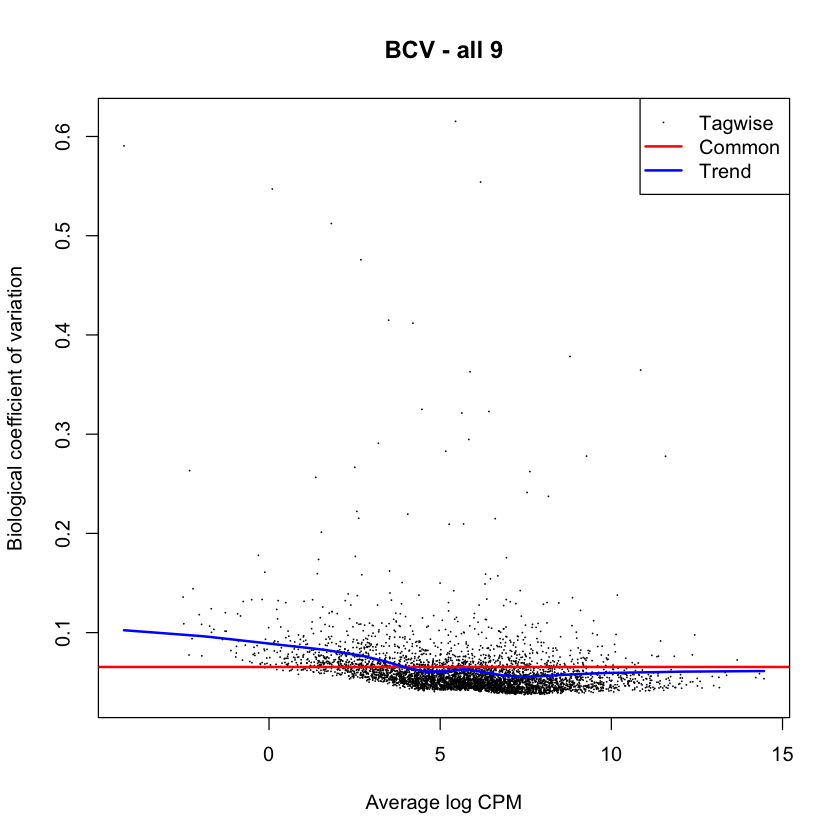

In [10]:
# dispersion
y <- estimateDisp(y, design, robust = TRUE)
round(y$common.dispersion, 6)
plotBCV(y, main = "BCV - all 9")

## Run the generalized linear models (with quasi-likelihood)

In [11]:
fit <- glmQLFit(y, design, robust = TRUE)

## There seems to be glm dispersion component

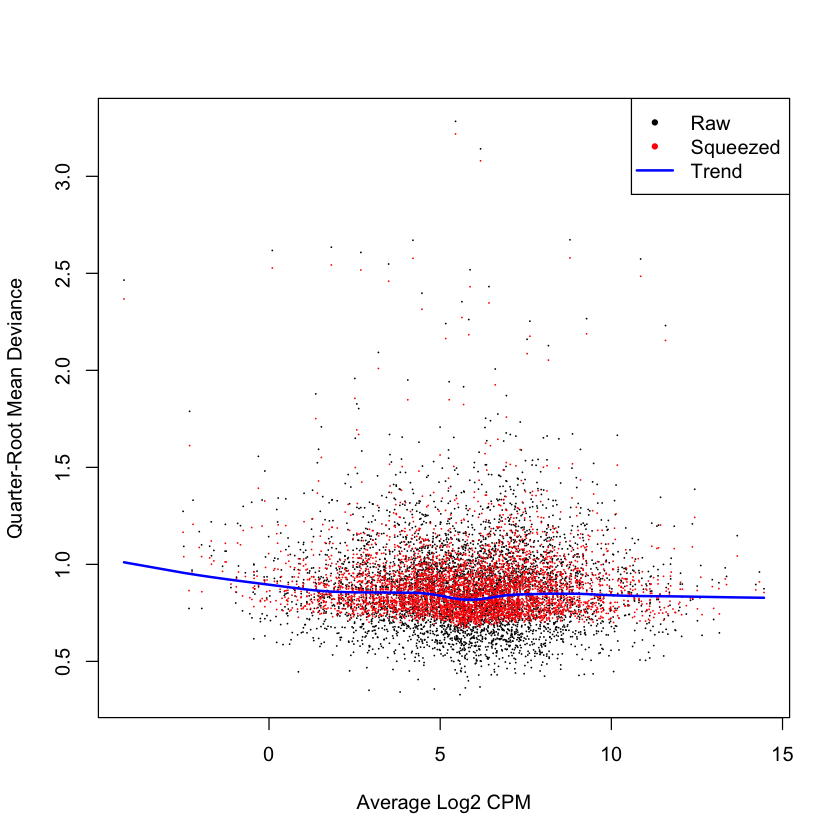

In [12]:
plotQLDisp(fit)

---

## Examine one pairwise test with linear modeling 

Let's do the Galactose versus glucose comparison using the linear modeling instead of the exact test. We need a different contrast.

,gal - glu
gal,1
glu,-1
raf,0


,genes,logFC,logCPM,F,PValue,FDR
2124,sp|P40017|YAT2_YEAST,-2.979162,8.636449,2646.826,3.979533e-14,1.105316e-10
3279,sp|P80235|CACM_YEAST,-3.277484,7.833201,2374.703,7.080781e-14,1.105316e-10
1215,sp|P32907|ATO2_YEAST,-2.786869,4.112160,2372.692,7.112718e-14,1.105316e-10
3325,sp|Q01574|ACS1_YEAST,-2.250014,8.775355,1867.282,2.536093e-13,2.453881e-10
4397,sp|Q12289|CRC1_YEAST,-3.996313,7.229292,1856.919,2.631790e-13,2.453881e-10
889,sp|P28240|ACEA_YEAST,-3.839650,9.856680,1762.550,3.444410e-13,2.676307e-10
2436,sp|P41939|IDHC_YEAST,-3.017683,7.751381,1614.319,5.487439e-13,3.654634e-10
4477,sp|Q12428|PRPD_YEAST,-1.407076,7.903394,1555.644,6.676949e-13,3.866400e-10
2068,sp|P39932|STL1_YEAST,-2.457960,2.446688,1518.000,7.602276e-13,3.866400e-10
246,sp|P08679|CISY2_YEAST,-3.126243,8.119938,1493.270,8.293436e-13,3.866400e-10


       1*gal -1*glu
Down           2017
NotSig          604
Up             2041

,genes,logFC,unshrunk.logFC,logCPM,PValue,FDR
2124,sp|P40017|YAT2_YEAST,-2.979162,-2.979162,8.636449,8.431362e-14,2.633536e-10
3279,sp|P80235|CACM_YEAST,-3.277484,-3.277484,7.833201,1.299085e-13,2.633536e-10
1215,sp|P32907|ATO2_YEAST,-2.786869,-2.786870,4.112160,1.694682e-13,2.633536e-10
4397,sp|Q12289|CRC1_YEAST,-3.996313,-3.996313,7.229292,3.860871e-13,4.499846e-10
889,sp|P28240|ACEA_YEAST,-3.839650,-3.839650,9.856680,5.247786e-13,4.893035e-10
3325,sp|Q01574|ACS1_YEAST,-2.250014,-2.250014,8.775355,9.864405e-13,7.566206e-10
2436,sp|P41939|IDHC_YEAST,-3.017683,-3.017683,7.751381,1.136067e-12,7.566206e-10
246,sp|P08679|CISY2_YEAST,-3.126243,-3.126243,8.119938,1.624688e-12,9.467871e-10
2068,sp|P39932|STL1_YEAST,-2.457960,-2.457963,2.446688,2.353622e-12,1.195195e-09
463,sp|P16467|PDC5_YEAST,-3.254346,-3.254347,5.745279,2.756534e-12,1.195195e-09


       1*gal -1*glu
Down            745
NotSig         3362
Up              555

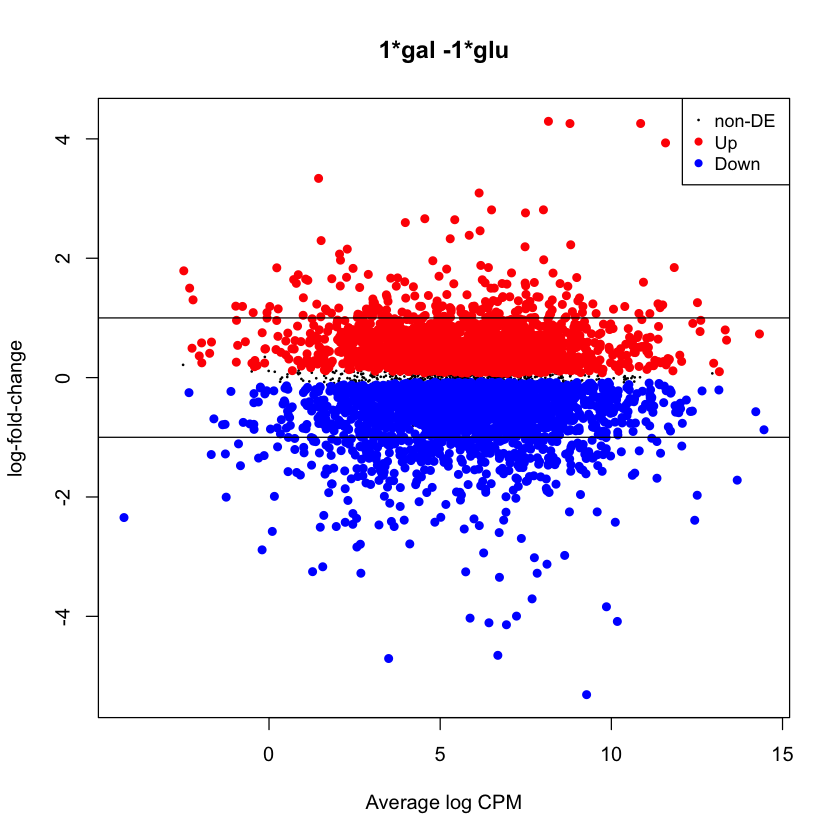

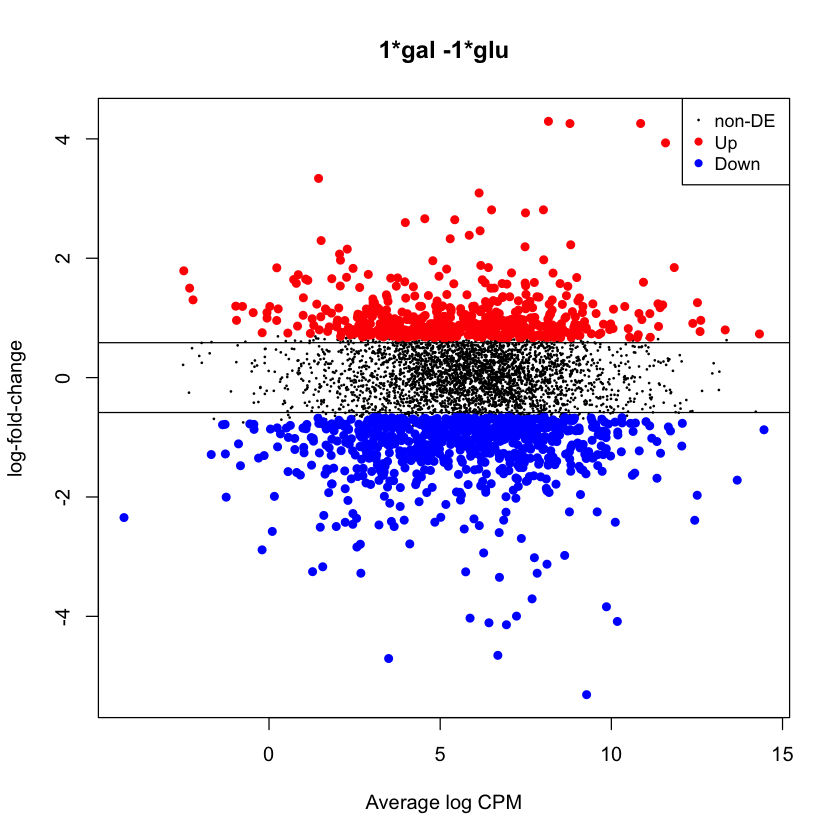

In [13]:
con1 <- makeContrasts(gal - glu, levels = design)
con1

qlf <- glmQLFTest(fit, contrast = con1)
topTags(qlf)
summary(decideTests(qlf, p.value = 0.10))

plotMD(qlf, p.value = 0.10)
abline(h = c(-1, 1), col = "black")

tr <- glmTreat(fit, contrast = con1, lfc = log2(1.5))
topTags(tr)

summary(decideTests(tr, p.value = 0.10))

plotMD(tr, p.value = 0.1)
abline(h = c(-0.585, 0.585), col = "black")

### Summary number are similar
We had 633 **NotSif** proteins with the exact test at an FDR of 10%. We had balalnced up and down regulated candidate numbers, like we have here.

### Visualize candidates with an MA plot

### There are too many candidates!

We can specify a minimum fold-change and recompute the p-values to narrow down the candidates to the more likely drivers. We can pick something like 1.5 fold or greater.

## What about an ANOVA test?

The Paulo et al. publication reported 1003 DE candidates using a on-way ANOVA test with a corrected p-value cutoff of 0.01. We can do a similar test in edgeR using generalized linear modeling extensions. Things get more complicated when you go down this road. The edgeR User Guide is really needed unless you use edgeR and limma a lot more than I do. I followed the worked example 4.4 "RNA-Seq profiles of mouse mammary gland" section. Subsection 4.4.9 was particularly relevant.

> McCarthy, D.J., Chen, Y. and Smyth, G.K., 2012. Differential expression analysis of multifactor RNA-Seq experiments with respect to biological variation. Nucleic acids research, 40(10), pp.4288-4297.

### Start over with a new DGEList object

The linear modeling is using underlying R functions. I do not yet know enough about what is going on under the hood. Design matrices and contrasts are how it all works. Just imitate the example...

In [14]:
con <- makeContrasts(gal.glu = gal - glu,
                     gal.raf = gal - raf,
                     glu.raf = glu - raf, levels = design)
con

anov <- glmQLFTest(fit, contrast = con)
topTags(anov)

summary(decideTests(anov, p.value = 0.01))

,gal.glu,gal.raf,glu.raf
gal,1,1,0
glu,-1,0,1
raf,0,-1,-1


,genes,logFC.gal.glu,logFC.gal.raf,logFC.glu.raf,logCPM,F,PValue,FDR
432,sp|P15202|CATA_YEAST,-0.4804168,-3.176395,-2.695978,4.108292,2569.903,4.886089e-15,7.891295e-12
3325,sp|Q01574|ACS1_YEAST,-2.2500142,-3.846427,-1.596413,8.775355,2501.525,5.640007e-15,7.891295e-12
4018,sp|Q07500|NDH2_YEAST,0.5473506,-2.286164,-2.833515,7.976351,2404.173,6.966292e-15,7.891295e-12
2202,sp|P40188|RGI2_YEAST,-2.5970596,-5.370839,-2.773779,6.723162,2379.733,7.355468e-15,7.891295e-12
98,sp|P04710|ADT1_YEAST,0.7080256,-2.659014,-3.367039,6.730922,2247.567,9.968422e-15,7.891295e-12
1501,sp|P36156|GTO2_YEAST,0.8095527,-1.765061,-2.574614,8.583363,2239.700,1.015611e-14,7.891295e-12
2197,sp|P40168|YNT5_YEAST,-0.2444570,-2.685894,-2.441437,5.436421,2054.968,1.605365e-14,9.121502e-12
1215,sp|P32907|ATO2_YEAST,-2.7868687,-3.806276,-1.019407,4.112160,2024.672,1.737317e-14,9.121502e-12
3057,sp|P53319|6PGD2_YEAST,1.5296567,-1.399479,-2.929136,8.729230,2019.544,1.760908e-14,9.121502e-12
1417,sp|P36035|JEN1_YEAST,-1.7857163,-3.817312,-2.031595,8.383256,1921.985,2.291318e-14,1.068212e-11


       LR test on 2 degrees of freedom
NotSig                             412
Sig                               4250

## 4249 is not in very good agreement with 1003

We do not have a Bonferroni multiple testing correction available in the edgeR function, so we have used the default Benjamini-Hochberg method. BH might be a little less conservative, but it cannot account for the difference. We were seeing large numbers of DE candidates in each pairwise test (about 4000 in each), so the number of proteins significant in **just one of the three** tests would be expected to be very large.

What are some differences between the PAW analysis and the original publication? A big one is that PAW uses reporter ion peak heights (intensities) instead of signal-to-noise ratios. Ratios would be expected to have a compressed dynamic range that could affect things. The noise levels are usually the same for all the channels (I think), so I would expect the relative expression pattern across the channels to be preserved. The within group verses between group characteristics of the data suggest that there should be a **lot** of DE candidates. I do not think that 1000 out of 4700 is correct for this data.

Another difference could be that the edgeR framework differs from a more traditional one-way ANOVA test. EdgeR has an different normalization method. Its correction factors were small. We can skip the TMM normalization and we get a similar number of candidates (about 4300, data not shown). We can do an ANOVA test in R. The dispersion estimates in edgeR use wider pooled variance estimates to make testing in studies with small replicate numbers more robust. That tends to be more conservative than t-tests. We can do the testing in a more traditional way and see how things compare.